# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
import math
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent(nn.Module):
    def __init__(self, env, state_size, action_size, h_size=128):
        super(Agent, self).__init__()
        # state, hidden layer, action sizes
        self.s_size = state_size
        self.h_size = h_size
        self.a_size = action_size
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.h_size)
        self.fc3 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_end = fc1_end + (h_size*h_size)+h_size
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*h_size)].reshape(h_size, h_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*h_size):fc2_end])
        fc3_W = torch.from_numpy(weights[fc2_end:fc2_end+(h_size*a_size)].reshape(h_size, a_size))
        fc3_b = torch.from_numpy(weights[fc2_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        self.fc3.weight.data.copy_(fc3_W.view_as(self.fc3.weight.data))
        self.fc3.bias.data.copy_(fc3_b.view_as(self.fc3.bias.data))

    def get_weights(self):
        weights = np.concatenate((self.fc1.weight.data.numpy().reshape(-1), 
                            self.fc1.bias.data.numpy().reshape(-1), 
                            self.fc2.weight.data.numpy().reshape(-1), 
                            self.fc2.bias.data.numpy().reshape(-1),
                            self.fc3.weight.data.numpy().reshape(-1), 
                            self.fc3.bias.data.numpy().reshape(-1)), axis=0)
        return weights.reshape(-1)
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x.cpu().data
        


def evaluate(agents, env, best_weight, sigma, env_info):
    
    gamma=1.0
    max_t=5000

    weights = []
    for idx, agent in enumerate(agents): # Try to keep one original
        weight_count = agent.get_weights_dim()
        if idx == 0:
            weight = best_weight
        else:
            weight = best_weight + (np.random.uniform(0.0, sigma) * np.random.choice(2, size=weight_count, p=[0.2, 0.8]) * np.random.randn(weight_count)) # .RandomState()
        agent.set_weights(weight)
        weights.append(weight)

    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_return = np.zeros(num_agents)
    for t in range(max_t):
        states = torch.from_numpy(states).float().to(device)
        actions = []
        for idx, agent in enumerate(agents):
            action = agent.forward(states[idx])
            actions.append(action.numpy())
        actions = np.array(actions)
        env_info = env.step(actions)[brain_name]
        states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        episode_return = episode_return + np.array(rewards) * math.pow(gamma, t)
        if np.array(dones).any():
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            # break

    return (weights, episode_return, env_info)



def cem(n_iterations=10000, gamma=1.0, print_every=10, elite_frac=0.20, sigma=0.5):
   
    np.random.seed(101)

    agents = []

    print("Agent count: ", num_agents)
    for _ in range(num_agents):
        agents.append(Agent(env, state_size, action_size))


    new_born_count = 3

    scores_deque = deque(maxlen=100)
    scores = []

    agents[0].load_state_dict(torch.load('checkpoint.pth'))

    best_weights = []
    for _ in range(new_born_count):
        best_weight = agents[0].get_weights()
        best_weights.append(best_weight)

   
    last_reward = -5000

    env_info = env.reset(train_mode=True)[brain_name]
   
    for i_iteration in range(1, n_iterations+1):
        
        weights_pop = []
        rewards = np.array([])
        for best_weight in best_weights:
            weights_and_rewards = evaluate(agents, env, best_weight, sigma, env_info)
            weights_it, rewards_it, env_info = weights_and_rewards
           
            weights_pop.extend(weights_it)
            rewards = np.concatenate((rewards , rewards_it))
       
        population = rewards.shape[0]
        n_elite = max(1, int(population*elite_frac))
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = np.array([weights_pop[i] for i in elite_idxs])
        elite_rewards = np.array([rewards[i] for i in elite_idxs])
        avg_weight = np.arange(n_elite) + np.ones(n_elite)
        best_weight_avg = np.average(elite_weights, axis=0,  weights=avg_weight)
        best_weight_rewards = np.average(elite_weights, axis=0,  weights=elite_rewards)
        best_weights = np.average(elite_weights, axis=0)

        best_weights = [best_weight_avg, best_weight_rewards, best_weights]

        reward = rewards.mean()
        
        if reward > last_reward:
            sigma = max(0.3, sigma * 0.95)

        else:
            sigma = min(0.75, sigma * 1.05)
        
        last_reward = reward
        
        scores_deque.append(reward)
        scores.append(reward)
        
        
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}  sigma: {:.2f} elite fra:c {:.2f}'.format(i_iteration, np.mean(scores_deque), sigma, elite_frac))
            agents[0].set_weights(best_weights[0])
            torch.save(agents[0].state_dict(), 'checkpoint.pth')
            
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores



Agent count:  20
initial :  21380
Episode 10	Average Score: 21.78  sigma: 0.37 elite fra:c 0.20
Episode 20	Average Score: 22.26  sigma: 0.36 elite fra:c 0.20
Episode 30	Average Score: 22.78  sigma: 0.33 elite fra:c 0.20
Episode 40	Average Score: 22.98  sigma: 0.30 elite fra:c 0.20
Episode 50	Average Score: 23.29  sigma: 0.30 elite fra:c 0.20
Episode 60	Average Score: 23.16  sigma: 0.33 elite fra:c 0.20
Episode 70	Average Score: 23.16  sigma: 0.30 elite fra:c 0.20
Episode 80	Average Score: 23.19  sigma: 0.33 elite fra:c 0.20
Episode 90	Average Score: 23.20  sigma: 0.36 elite fra:c 0.20
Episode 100	Average Score: 23.14  sigma: 0.39 elite fra:c 0.20
Episode 110	Average Score: 23.25  sigma: 0.43 elite fra:c 0.20
Episode 120	Average Score: 23.22  sigma: 0.42 elite fra:c 0.20
Episode 130	Average Score: 23.15  sigma: 0.38 elite fra:c 0.20
Episode 140	Average Score: 23.16  sigma: 0.34 elite fra:c 0.20
Episode 150	Average Score: 23.12  sigma: 0.37 elite fra:c 0.20
Episode 160	Average Score: 23.

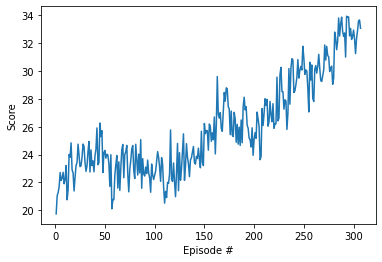

In [6]:
scores = cem()  

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("evolution.png")
plt.show()

In [7]:

agent = Agent(env, state_size, action_size)
agent.load_state_dict(torch.load('checkpoint.pth'))



for _ in range(10):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)


    while True:
        actions = []
        for i in range(num_agents):
            action = agent.forward(torch.tensor(states[i], dtype=torch.float)).detach().numpy()
            actions.append(action)
        actions = np.array(actions)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 6.9574998444877565
Total score (averaged over agents) this episode: 6.292499859351665
Total score (averaged over agents) this episode: 6.0604998645372685
Total score (averaged over agents) this episode: 6.354999857954681
Total score (averaged over agents) this episode: 6.582999852858483
Total score (averaged over agents) this episode: 5.252499882597476
Total score (averaged over agents) this episode: 7.345999835804105
Total score (averaged over agents) this episode: 7.324999836273491
Total score (averaged over agents) this episode: 9.021999798342586
Total score (averaged over agents) this episode: 7.699499827902764


When finished, you can close the environment.

In [8]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```